# Neural Network Evaluation
Now we  want to test that our methodology is working well. The best way to do this is to see how our neural network selection works on a similar decay. In this case via a $J/\psi$.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
version = '7.0.2'
train = pd.read_csv(f'../data_files/{version}/train.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

all = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
raw = pd.read_csv('../data_files/0.0.1/all.csv', index_col=[0])

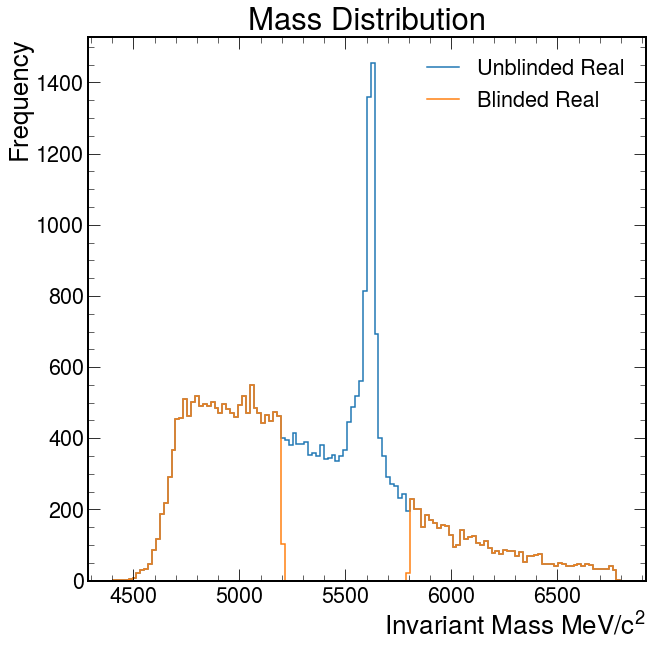

In [3]:
h1, bins = np.histogram(raw['Lb_M'][raw['IsSimulated']==False], bins=130)
h, _ = np.histogram(all['Lb_M'][all['IsSimulated']==False], bins=bins)

fig, ax = plt.subplots(1, 1)
hep.histplot([h1, h], bins=bins, ax=ax, label=['Unblinded Real', 'Blinded Real'])
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.title('Mass Distribution')
#plt.savefig('../images/Normalisation/RealData_Before_And_After_Reblind.png')
plt.legend()
plt.show()

## Evaluate without Re-Training ~ BROKEN AND BUGGY

In [4]:
orig_model = tf.keras.models.load_model('../neural_network/models/v7.0.2')
orig_model.summary()

2022-03-17 09:02:22.600065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 09:02:22.605229: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2

In [5]:
preds = orig_model.predict(X_train).flatten()
preds

2022-03-17 09:02:27.296201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-17 09:02:27.310714: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


array([9.9992156e-01, 4.1911781e-02, 9.9998724e-01, ..., 9.9938941e-01,
       2.2950768e-04, 9.9998266e-01], dtype=float32)

In [6]:
accuracy_score(y_train, np.where(preds>0.8,1,0))

0.8514527114406414

In [7]:
pred_test = orig_model.predict(X_test).flatten()
accuracy_score(y_test, np.where(pred_test>0.8,1,0))

0.8551848978536333

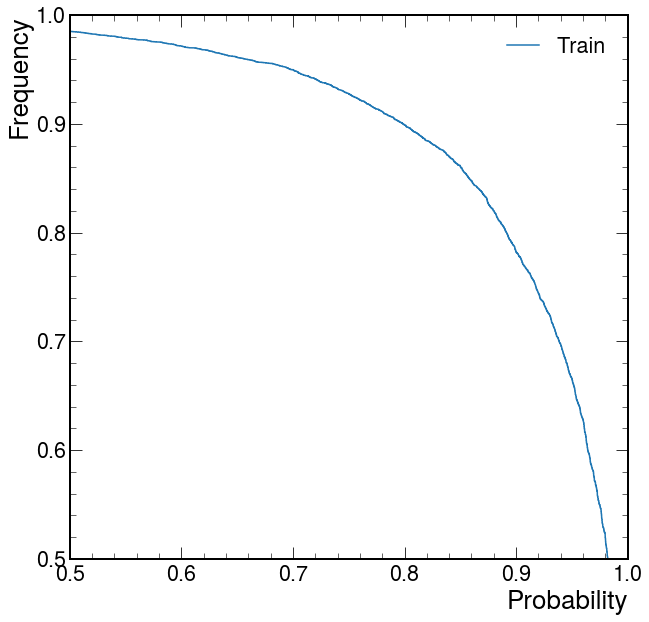

In [8]:
roc = roc_curve(y_train, preds)
fig, ax = plt.subplots(1, 1)
ax.plot(roc[1], 1-roc[0], label='Train')
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend()
plt.show()

## Evaluate with Retraining

In [9]:
from tensorflow.keras import callbacks

custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=10, factor=0.2, min_lr=0.001)
    ]

model = tf.keras.models.load_model('../neural_network/models/v7.0.2')
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/100
46/46 [==============================] - 4s 34ms/step - loss: 0.2595 - binary_accuracy: 0.9030 - auc: 0.9649 - true_positives: 10533.0000 - true_negatives: 10414.0000 - false_positives: 1164.0000 - false_negatives: 1087.0000 - val_loss: 0.1915 - val_binary_accuracy: 0.9311 - val_auc: 0.9821 - val_true_positives: 3597.0000 - val_true_negatives: 3604.0000 - val_false_positives: 260.0000 - val_false_negatives: 273.0000
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: 0.2323 - binary_accuracy: 0.9126 - auc: 0.9722 - true_positives: 10624.0000 - true_negatives: 10547.0000 - false_positives: 1031.0000 - false_negatives: 996.0000 - val_loss: 0.1899 - val_binary_accuracy: 0.9307 - val_auc: 0.9831 - val_true_positives: 3558.0000 - val_true_negatives: 3640.0000 - val_false_positives: 224.0000 - val_false_negatives: 312.0000
Epoch 3/100
46/46 [==============================] - 1s 16ms/step - loss: 0.2267 - binary_accuracy: 0.9155 - auc: 0.9736 - true_positives

In [11]:
pred_test = model.predict(X_test).flatten()
accuracy_score(y_test, np.where(pred_test>0.8,1,0))

0.9237134729764676

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

z = all.drop(['Lb_M', 'IsSimulated', 'category'], axis=1)

cols_to_transform = z.columns.to_list()
# The columns to apply the transformer to 

ct = ColumnTransformer([('normaliser', StandardScaler(), cols_to_transform)], remainder='passthrough')

ct.fit(z)
# Get the values for the normaliser from X_train
alls = ct.transform(z)

all_normalised = pd.DataFrame(alls, index=z.index, columns=z.columns).fillna(0)
# In case you divide by a zero std. dev. fill the NaNs with zeros
all_normalised['Lb_M'] = all['Lb_M']
all_normalised['IsSimulated'] = all['IsSimulated']
all_normalised['category'] = all['category']

# Output all these files
all_normalised.head()

,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,...,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA,Lb_M,IsSimulated,category
0,0.701095,-0.347287,-0.347287,1.028588,1.155121,1.028588,1.547557,0.892961,0.625776,-0.724314,...,0.617128,-0.176320,-0.492708,-0.123007,1.133626,-0.353986,0.425062,5880.217343,False,0
1,0.265025,-0.252682,-0.252682,0.502136,0.330604,0.502136,-0.326694,0.983121,0.595046,0.474523,...,0.761549,-0.178233,0.409900,1.083683,0.734056,-0.657777,0.404687,5603.892537,True,1
2,-0.219032,0.074720,0.074720,0.726955,0.480310,0.726955,-1.072143,-0.829637,0.259309,-0.538288,...,-0.744674,-0.049604,-0.471160,-0.347112,-1.024222,-0.520847,0.354488,5116.687991,False,0
3,0.881301,-0.389589,-0.389589,-1.494515,-0.681030,-1.494515,1.779921,0.171416,-1.323135,-1.117457,...,-0.203419,-0.047095,-0.364132,-1.089861,0.117673,-0.906406,0.433648,6537.913429,False,0
4,-0.171925,0.776629,0.776629,1.241820,-0.935599,1.241820,-1.895715,-0.148841,1.501475,-0.177746,...,-0.430383,0.107222,1.129610,-1.289068,0.399256,0.125558,-1.126998,4651.048269,False,0


In [19]:
all_preds = model.predict(all_normalised.drop(['Lb_M', 'IsSimulated', 'category'], axis=1)).flatten()

In [23]:
all_normalised['predcat'] = np.where(all_preds > 0.8, 1, 0)

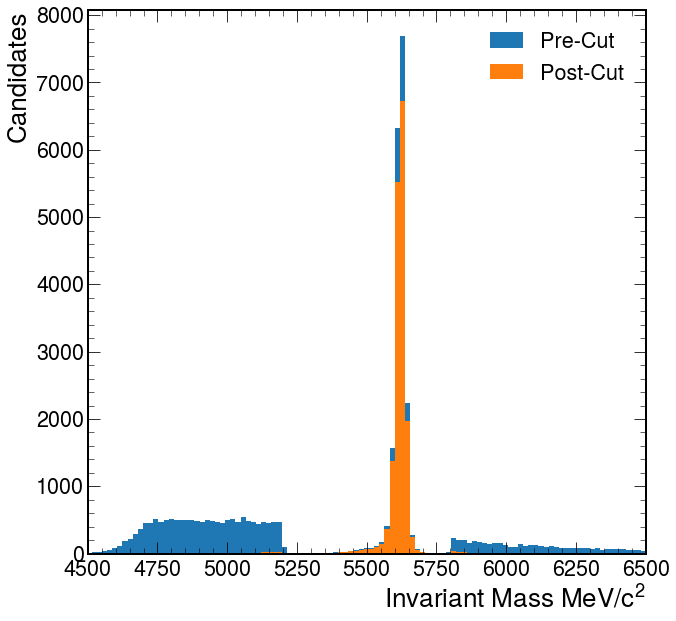

In [26]:
h, bins = np.histogram(all_normalised['Lb_M'], bins=130)
hcut, _ = np.histogram(all_normalised['Lb_M'][all_normalised['predcat']==1], bins=bins)

fig, ax = plt.subplots(1, 1)
hep.histplot([h, hcut], bins, ax=ax, label=['Pre-Cut', 'Post-Cut'], histtype='fill')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.ylabel('Candidates')
plt.xlim(4500, 6500)
plt.legend()
plt.savefig('../images/normalisation_retrained_massdist_prepostcut.png', dpi=800)
plt.show()